In [ ]:
import pandas as pd
import numpy as np

# text preprocessing
from nltk.tokenize import word_tokenize
import re

# plots
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

# preparing input to the  model
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

# keras layers
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense

In [ ]:
# Number of labels: joy, anger, fear, sadness, neutral
num_classes = 5

# Number of dimensions for word embedding
embed_num_dims = 300

# Max input length (max number of words)
max_seq_len = 500

class_names = ['joy', 'fear', 'anger', 'sadness', 'neutral']

In [ ]:
data_train = pd.read_csv('data_train.csv')
data_test = pd.read_csv('data_test.csv')

X_train = data_train.Text
X_test = data_test.Text

y_train = data_train.Emotion
y_test = data_test.Emotion

data = data_train.append(data_test)

<ipython-input-4-aee6c9c164af>:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data_train.append(data_test)


In [ ]:
print(data)

      Emotion                                               Text
0     neutral   There are tons of other paintings that I thin...
1     sadness  Yet the dog had grown old and less capable , a...
2        fear  When I get into the tube or the train without ...
3        fear  This last may be a source of considerable disq...
4       anger  She disliked the intimacy he showed towards so...
...       ...                                                ...
3388  sadness  My sweetheart left me, or rather we decided to...
3389  sadness  Well , it's too bad that we like different kin...
3390  neutral                                      It sure is . 
3391  sadness  He ’ s got laid off again . I do feel sorry fo...
3392    anger  When stupid people push me during rush time in...

[11327 rows x 2 columns]


In [ ]:
print(data.Emotion.value_counts())
data.head(10)

joy        2326
sadness    2317
anger      2259
neutral    2254
fear       2171
Name: Emotion, dtype: int64


,Emotion,Text
0,neutral,There are tons of other paintings that I thin...
1,sadness,"Yet the dog had grown old and less capable , a..."
2,fear,When I get into the tube or the train without ...
3,fear,This last may be a source of considerable disq...
4,anger,She disliked the intimacy he showed towards so...
5,sadness,When my family heard that my Mother's cousin w...
6,joy,Finding out I am chosen to collect norms for C...
7,anger,A spokesperson said : ` Glen is furious that t...
8,neutral,Yes .
9,sadness,"When I see people with burns I feel sad, actua..."


In [ ]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
def clean_text(data):

    # remove hashtags and @usernames
    data = re.sub(r"(#[\d\w\.]+)", '', data)
    data = re.sub(r"(@[\d\w\.]+)", '', data)

    # tekenization using nltk
    data = word_tokenize(data)

    return data

In [ ]:
texts = [' '.join(clean_text(text)) for text in data.Text]
texts_train = [' '.join(clean_text(text)) for text in X_train]
texts_test = [' '.join(clean_text(text)) for text in X_test]


In [ ]:
print(texts_train[67])

I was with my girlfriend when some guys that I do n't like made fuss at my girl .


In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(texts)

sequence_train = tokenizer.texts_to_sequences(texts_train)
sequence_test = tokenizer.texts_to_sequences(texts_test)

index_of_words = tokenizer.word_index

# vacab size is number of unique words + reserved 0 index for padding
vocab_size = len(index_of_words) + 1

print('Number of unique words: {}'.format(len(index_of_words)))

Number of unique words: 12087


In [ ]:
X_train_pad = pad_sequences(sequence_train, maxlen = max_seq_len )
X_test_pad = pad_sequences(sequence_test, maxlen = max_seq_len )

X_train_pad

array([[    0,     0,     0, ...,   119,    51,   345],
       [    0,     0,     0, ...,    37,   277,   154],
       [    0,     0,     0, ...,    16,     2,  1210],
       ...,
       [    0,     0,     0, ...,   876,     4,   909],
       [    0,     0,     0, ...,     1,     6,   117],
       [    0,     0,     0, ..., 10258,   173,    13]], dtype=int32)

In [ ]:
encoding = {
    'joy': 0,
    'sadness': 1,
    'fear': 2,
    'anger': 3,
    'neutral': 4
}
# Integer labels
y_train = [encoding[x] for x in data_train.Emotion]
y_test = [encoding[x] for x in data_test.Emotion]

In [ ]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

y_train

array([[0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.]], dtype=float32)

In [ ]:
def create_embedding_matrix(filepath, word_index, embedding_dim):
    vocab_size = len(word_index) + 1  # Adding again 1 because of reserved 0 index
    embedding_matrix = np.zeros((vocab_size, embedding_dim))
    with open(filepath) as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word]
                embedding_matrix[idx] = np.array(
                    vector, dtype=np.float32)[:embedding_dim]
    return embedding_matrix

In [ ]:
import urllib.request
import zipfile
import os

fname = 'embeddings/wiki-news-300d-1M.vec'

if not os.path.isfile(fname):
    print('Downloading word vectors...')
    urllib.request.urlretrieve('https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M.vec.zip',
                              'wiki-news-300d-1M.vec.zip')
    print('Unzipping...')
    with zipfile.ZipFile('wiki-news-300d-1M.vec.zip', 'r') as zip_ref:
        zip_ref.extractall('embeddings')
    print('done.')

    os.remove('wiki-news-300d-1M.vec.zip')

Unzipping...
done.


In [ ]:
embedd_matrix = create_embedding_matrix(fname, index_of_words, embed_num_dims)
embedd_matrix.shape

(12088, 300)

In [ ]:
# Inspecting the unseen words
new_words = 0

for word in index_of_words:
    entry = embedd_matrix[index_of_words[word]]
    if all(v == 0 for v in entry):
        new_words = new_words + 1

print('Words found in wiki vocab: ' + str(len(index_of_words) - new_words))
print('New words found: ' + str(new_words))

Words found in wiki vocab: 11442
New words found: 645


In [ ]:
embedd_layer = Embedding(vocab_size,
                         embed_num_dims,
                         input_length = max_seq_len,
                         weights = [embedd_matrix],
                         trainable=False)

In [ ]:
# Convolution
kernel_size = 3
filters = 256

model = Sequential()
model.add(embedd_layer)
model.add(Conv1D(filters, kernel_size, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(256, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

In [ ]:
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 500, 300)          3626400   
                                                                 
 conv1d_1 (Conv1D)           (None, 498, 256)          230656    
                                                                 
 global_max_pooling1d_1 (Glo  (None, 256)              0         
 balMaxPooling1D)                                                
                                                                 
 dense_2 (Dense)             (None, 256)               65792     
                                                                 
 dense_3 (Dense)             (None, 5)                 1285      
                                                                 
Total params: 3,924,133
Trainable params: 297,733
Non-trainable params: 3,626,400
______________________________________

In [ ]:
batch_size = 256
epochs = 10

hist = model.fit(X_train_pad, y_train,
                 batch_size=batch_size,
                 epochs=epochs,
                 validation_data=(X_test_pad,y_test))

Epoch 1/10
31/31 [==============================] - 72s 2s/step - loss: 0.2044 - accuracy: 0.9569 - val_loss: 0.7193 - val_accuracy: 0.7660
Epoch 2/10
31/31 [==============================] - 72s 2s/step - loss: 0.1433 - accuracy: 0.9774 - val_loss: 0.7291 - val_accuracy: 0.7636
Epoch 3/10
31/31 [==============================] - 102s 3s/step - loss: 0.1035 - accuracy: 0.9855 - val_loss: 0.7645 - val_accuracy: 0.7513
Epoch 4/10
31/31 [==============================] - 86s 3s/step - loss: 0.0776 - accuracy: 0.9898 - val_loss: 0.7790 - val_accuracy: 0.7574
Epoch 5/10
31/31 [==============================] - 78s 2s/step - loss: 0.0608 - accuracy: 0.9918 - val_loss: 0.7922 - val_accuracy: 0.7627
Epoch 6/10
31/31 [==============================] - 74s 2s/step - loss: 0.0487 - accuracy: 0.9929 - val_loss: 0.8396 - val_accuracy: 0.7554
Epoch 7/10
31/31 [==============================] - 73s 2s/step - loss: 0.0411 - accuracy: 0.9938 - val_loss: 0.8671 - val_accuracy: 0.7601
Epoch 8/10
31/31 [=

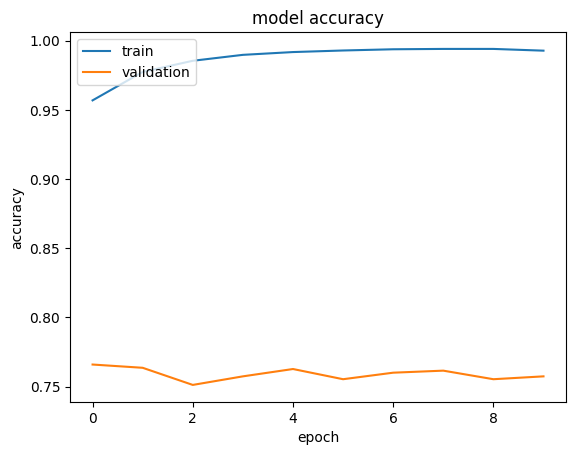

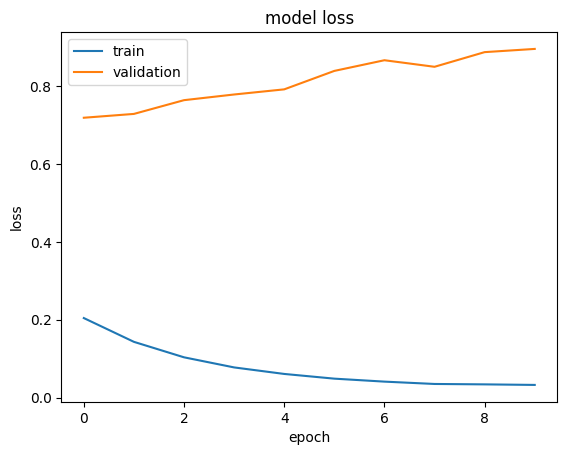

In [ ]:
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# Loss plot
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
predictions = model.predict(X_test_pad)
predictions = np.argmax(predictions, axis=1)
predictions = [class_names[pred] for pred in predictions]


107/107 [==============================] - 11s 105ms/step


In [ ]:
print("Accuracy: {:.2f}%".format(accuracy_score(data_test.Emotion, predictions) * 100))
print("\nF1 Score: {:.2f}".format(f1_score(data_test.Emotion, predictions, average='micro') * 100))

In [ ]:
print('Message: {}\nPredicted: {}'.format(X_test[4], predictions[4]))

Message: My boyfriend didn't turn up after promising that he was coming.
Predicted: fear


In [ ]:
import time

message = ["It deserves . That film can give us a lot of inspiration ."]

seq = tokenizer.texts_to_sequences(message)
padded = pad_sequences(seq, maxlen=max_seq_len)

start_time = time.time()
pred = model.predict(padded)

print('Message: ' + str(message))
print('predicted: {} ({:.2f} seconds)'.format(class_names[np.argmax(pred)], (time.time() - start_time)))

1/1 [==============================] - 0s 28ms/step
Message: ['It deserves . That film can give us a lot of inspiration .']
predicted: joy (0.08 seconds)


In [ ]:
import pickle
filename= 'train_model.sav'
pickle.dump(model , open(filename,'wb'))

In [ ]:
loaded_model= pickle.load(open('train_model.sav','rb'))